## 1. 데이터 준비

In [1]:
%matplotlib inline
# Standard library imports
import datetime
from datetime import datetime
import os
from copy import deepcopy
import pickle

# Third-party libraries imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import seaborn as sns
import random
from itertools import combinations

# from IPython.display import clear_output
from scipy.spatial import distance
from sklearn.decomposition import PCA

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision import datasets, transforms

# Local application/library specific imports
from data_utils import (generate_server_idcs, CustomSubset, split_3class_unbalanced, split_contain_multiclass,
                        split_7plus3class_unbalanced, CombinedCustomSubset)
from fl_devices import Server, Client
from helper import ExperimentLogger, display_train_stats
from models import ConvNet, Representation, Ten_class_classifier, Four_class_classifier, Net


torch.manual_seed(42)
np.random.seed(42)

In [2]:
LOCAL_EPOCHS = 25
N_CLIENTS = 6
NUMBER_OF_CLUSTER = 3
ALPHA = 0.1
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
data = datasets.CIFAR10(root="CIFAR10/", download=False)
#data = datasets.MNIST(root="MNIST/", download=False)
idcs = np.random.permutation(len(data))

def cluster(server, clients, number_of_cluster):
    label_predicted = pd.DataFrame()
    # label_acc = pd.DataFrame()
    for i, client in enumerate(clients):
        pred = server.check_cluster(client.model)
        # print(f'pred: {pred}')
        label_predicted = pd.concat([label_predicted, pd.DataFrame(pred, index=[i])])
        # label_acc = pd.concat([label_acc, pd.DataFrame(acc, index=[i])])
    label_predicted.reset_index(drop=True, inplace=True)
    label_predicted.fillna(0, inplace=True)
    
    print(f'predicted label')
    print(label_predicted)

    cluster_idcs, number_of_cluster= server.cluster_clients(label_predicted)
    return label_predicted, cluster_idcs, number_of_cluster



def get_cluster_averages(df, cluster_idcs):
    cluster_averages = {}

    for i, cluster in enumerate(cluster_idcs):
        cluster_data = df.loc[cluster, :]
        cluster_average = cluster_data.mean()
        cluster_averages[i] = cluster_average

    cluster_averages_df = pd.DataFrame(cluster_averages).T

    # calculate percentage for each value in a row
    cluster_percentages_df = cluster_averages_df.div(cluster_averages_df.sum(axis=1), axis=0).multiply(100)

    # apply threshold and rounding
    cluster_percentages_df = cluster_percentages_df.where(cluster_percentages_df >= 5, 0).round()

    return cluster_percentages_df / 10


def get_cluster_weights(cluster_logits, cluster_weight_per_class):
    # Step 1: Find the class with the maximum value in each logit in cluster_logits
    # Assuming the dimension for classes is the second one
    max_classes = [torch.argmax(logit, dim=1) for logit in cluster_logits]
    
    print(max_classes)
    cluster_weights = []
    #c luster별로 
    for i, iogits in enumerate(cluster_logits):
        weights = []
        for j, logit in enumerate(logits):
            
            # print(f'max_classes: {max_classes[i][j]}')
            # print("Shape of cluster_weight_per_class[{}]: ".format(i), cluster_weight_per_class[i].shape)
            weights.append(max_classes[i][j])
        print(weights)
        cluster_weights.append(weights)

        
def visualize_clusters(label_predicted, real_cluster_distribution):
    # Reduce the dimension of the data
    pca = PCA(n_components=2)
    label_predicted_pca = pca.fit_transform(label_predicted)
    
    # Define colors for the clusters
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    # Calculate the number of samples in each real cluster
    n_samples = len(label_predicted)
    real_cluster_sizes = [int(n_samples * dist) for dist in real_cluster_distribution]

    # Plot the clusters
    plt.figure(figsize=(8, 5))

    start_idx = 0  # To keep track of the start index of each real cluster
    for i, size in enumerate(real_cluster_sizes):
        end_idx = start_idx + size  # Calculate the end index for this real cluster
        color = colors[i % len(colors)]  # Determine the color for this real cluster

        # Scatter plot for points belonging to this real cluster
        for j in range(start_idx, end_idx):
            plt.scatter(label_predicted_pca[j, 0], label_predicted_pca[j, 1], c=color, s=50, label=f'Group {i+1}' if j == start_idx else "")

        start_idx = end_idx  # Update the start index for the next real cluster
    
    # Remove duplicate labels in legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize='xx-large')

    # Remove x and y ticks
    plt.xticks([])
    plt.yticks([])

    # # Save the figure with narrow margins
    # plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
    # current_time = datetime.now().strftime('%Y%m%d%H%M%S')
    # plt.savefig(f'Figures/cluster_visualization_{current_time}.png', dpi=300, format='png')

    
    plt.show()



#     # Print the real cluster distribution
#     print("Real cluster distribution:", real_cluster_distribution)

#     # Calculate and print each client's cluster identity based on the real_cluster_distribution
#     n_clients = len(label_predicted)
#     cumulative_distribution = [0] + [sum(real_cluster_distribution[:i+1]) for i in range(len(real_cluster_distribution))]
#     client_cluster_id_real = [next((i for i, val in enumerate(cumulative_distribution) if val > client_idx / n_clients), -1) - 1 for client_idx in range(n_clients)]

#     print("Real cluster identity for each client:", client_cluster_id_real)

#     # Print each client's cluster identity based on the clusters argument
#     client_cluster_id_predicted = [next((i for i, cluster in enumerate(clusters) if client_idx in cluster), -1) for client_idx in range(n_clients)]
#     print("Predicted cluster identity for each client:", client_cluster_id_predicted)




def test_acc(server, clients, cluster_distribution):
    
    # Get individual client accuracies
    acc_clients = [client.evaluate() for client in clients]

    # Compute the average accuracy for each client
    client_acc = round(sum(acc_clients) / len(acc_clients), 3) if len(acc_clients) > 0 else 0

    # Compute cluster accuracies for this iteration
    cluster_accs_iteration = []
    start_idx = 0
    for distribution in cluster_distribution:
        end_idx = start_idx + int(distribution * len(clients))
        cluster_acc = round(sum(acc_clients[start_idx:end_idx]) / (end_idx - start_idx) + 0.000001, 3)
        cluster_accs_iteration.append(cluster_acc)
        start_idx = end_idx

    # Compute global accuracy for this iteration
    accuracies = [server.evaluate_distil(client.classifier) for client in clients]
    global_acc = round(np.mean(accuracies), 3)
    
    return client_acc, cluster_accs_iteration, global_acc


def get_global_logits(client_logits):
    avg_logits = torch.mean(torch.stack(client_logits), dim=0)
    return avg_logits

# def get_cluster_logits(client_logits, cluster_idcs):
#     cluster_logits = []
#     for i, cluster in enumerate(cluster_idcs):
#         cluster_client_logits = [client_logits[i] for i in cluster]
#         avg_cluster_logits = torch.mean(torch.stack(cluster_client_logits), dim=0)
#         cluster_logits.append(avg_cluster_logits)
#     return cluster_logits


def get_cluster_averages(df, cluster_idcs):
    cluster_averages = {}

    for i, cluster in enumerate(cluster_idcs):
        cluster_data = df.loc[cluster, :]
        cluster_average = cluster_data.mean()
        cluster_averages[i] = cluster_average

    cluster_averages_df = pd.DataFrame(cluster_averages).T

    # calculate percentage for each value in a row
    cluster_percentages_df = cluster_averages_df.div(cluster_averages_df.sum(axis=1), axis=0).multiply(100)

    # apply threshold and rounding
    cluster_percentages_df = cluster_percentages_df.where(cluster_percentages_df >= 5, 0).round()

    return cluster_percentages_df / 10

def compute_accuracy(global_logits, data_targets, server_idcs):
    """
    Compute accuracy of predictions based on global logits.

    Args:
    - global_logits (list of Tensors): Each Tensor represents the logits for a data instance, 
                                       and its size is the number of classes.
    - data_targets (list of ints): List of true labels for all data.
    - server_idcs (list of ints): Indices of data instances we're interested in.

    Returns:
    - accuracy (float): Computed accuracy.
    """
    true_labels = [data_targets[i] for i in server_idcs]
    
    correct_predictions = 0
    total_predictions = len(true_labels)

    for logits, label in zip(global_logits, true_labels):
        predicted_label = np.argmax(logits.cpu().numpy())  # Convert Tensor to numpy and get index of max value
        if predicted_label == label:
            correct_predictions += 1

    accuracy = correct_predictions / total_predictions
    return accuracy


def save_tensor_to_csv(tensor, filename):
    # Convert tensor to numpy array
    array = tensor.cpu().detach().numpy()
    
    # Save numpy array to CSV file
    np.savetxt(filename, array, delimiter=",")

# def get_cluster_weights(cluster_logits, cluster_weight_per_class):
#     # Step 1: Find the class with the maximum value in each logit in cluster_logits
#     # Assuming the dimension for classes is the second one
#     max_classes = [torch.argmax(logit, dim=1) for logit in cluster_logits]
    
#     print(max_classes)
#     cluster_weights = []
#     #c luster별로 
#     for i, iogits in enumerate(cluster_logits):
#         weights = []
#         for j, logit in enumerate(logits):
            
#             # print(f'max_classes: {max_classes[i][j]}')
#             # print("Shape of cluster_weight_per_class[{}]: ".format(i), cluster_weight_per_class[i].shape)
#             weights.append(max_classes[i][j])
#         print(weights)
#         cluster_weights.append(weights)


### DS-FL

In [4]:
import torch
import torch.nn.functional as F
from scipy.special import kl_div

# Step 3: Apply softmax to get probability distribution
def apply_softmax(logits):
    return F.softmax(logits, dim=-1)

# Step 4: Average probability distributions
def average_prob_distributions(prob_distributions):
    return torch.mean(torch.stack(prob_distributions), dim=0)

# Step 5: Apply ERA technique to reduce entropy
def kl_divergence(p, q):
    return torch.sum(p * torch.log(p / q), dim=-1, keepdim=True)


def apply_ERA(avg_prob_distributions, local_prob_distributions, temperature=0.1):
    # Calculate reference distribution
    reference_distribution = apply_softmax(torch.mean(torch.stack(local_prob_distributions), dim=0))

    # Minimize KL divergence to reduce entropy, scaled by temperature
    kl_term = kl_divergence(avg_prob_distributions, reference_distribution)
    reduced_entropy_logits = avg_prob_distributions - temperature * kl_term

    return reduced_entropy_logits

# Step 1, 2, 3, 4, 5: Replace your existing function
def get_global_logits_DS_FL(client_logits, temperature=0.1):
    # Step 3: Apply softmax to each local logit
    client_prob_distributions = [apply_softmax(logits) for logits in client_logits]

    # Step 4: Average the probability distributions
    avg_prob_distributions = average_prob_distributions(client_prob_distributions)

    # Step 5: Apply ERA to the averaged logits
    reduced_entropy_logits = apply_ERA(avg_prob_distributions, client_prob_distributions, temperature)

    return reduced_entropy_logits.detach()

In [5]:
def make_global_logit(n_clients, total_client_data, distill_data, number_of_cluster, cluster_distribution, instance_per_class, instance_per_minor_class, instances_per_class_per_client):
    data_per_class=int(distill_data//10)
    train_idcs, test_idcs = idcs[:total_client_data], idcs[total_client_data:(total_client_data + int(distill_data * 2))]
    train_labels = data.targets
    test_labels = data.targets
    server_idcs = generate_server_idcs(test_idcs, test_labels, int(distill_data//10))
    print(f'sever idcs: {len(server_idcs)}')
    client_idcs, _ = split_7plus3class_unbalanced(train_idcs, train_labels, n_clients, cluster_distribution, instance_per_class, instance_per_minor_class)
    #client_idcs = split_contain_multiclass(train_idcs, train_labels, n_clients, instance_per_class, instances_per_class_per_client, cluster_distribution)
    
    client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
    test_data = CustomSubset(data, server_idcs, transforms.Compose([transforms.ToTensor()]))
    print(f'test_data: {len(test_data)}')
    
    for i, client_datum in enumerate(client_data):
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

    server = Server(ConvNet, lambda x : torch.optim.Adam(x),test_data)

    clients = [Client(Representation, dat, i) 
           for i, dat in enumerate(client_data) if len(dat) > 20]
    
    # print(f'client count: {len(clients)}')

    client_logits = []
    
        
    # 1. Train classifier
    for i, client in enumerate(clients):
        client.classifier = Ten_class_classifier(client.model).to(device)
        client.train_classifier(lr=1e-3)

    client_acc, cluster_accs, global_acc = test_acc(server, clients, cluster_distribution)
    
    # 2. get client loigt
    for i, client in enumerate(clients):
        client_logits.append(server.get_clients_logit(client.classifier))

    # 3. make global logit
    global_logits = server.get_global_logits(client_logits)
    accuracy = compute_accuracy(global_logits, test_labels, server_idcs)
    
    print(f"Global Logit's Accuracy: {accuracy * 100:.2f}%")
    
    return server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution, client_acc, cluster_accs, global_acc

def distill_with_cluster_logit(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution, t):
    cluster_logits,  cluster_idcs, label_predicted = server.get_cluster_logits(client_logits, number_of_cluster, t)
    visualize_clusters(label_predicted, cluster_distribution)
    silhouette, ari = server.evaluate_clustering(label_predicted, cluster_distribution, cluster_idcs)
    
    print(f'silhouette: {silhouette}, ari: {ari}')

    cluster_distill_loaders = []
    
    for cluster_logit in cluster_logits:
        distill_loader = server.create_distill_loader(data, server_idcs, cluster_logit)
        cluster_distill_loaders.append(distill_loader)
        
    for i, client in enumerate(clients):
        if i % 10 == 0:
            print(f'client {i} distill')
        
        cluster_idx = next(j for j, cluster in enumerate(cluster_idcs) if i in cluster)
        
        client.distill((cluster_distill_loaders[cluster_idx]))
    
    client_acc, cluster_accs, global_acc = test_acc(server, clients, cluster_distribution)
    
    return client_acc, cluster_accs, global_acc


def get_cluster_acc(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution, t):
    cluster_logits,  cluster_idcs, label_predicted = server.get_cluster_logits(client_logits, number_of_cluster, t)
    visualize_clusters(label_predicted, cluster_distribution)
    silhouette, ari = server.evaluate_clustering(label_predicted, cluster_distribution, cluster_idcs)
    
    print(f'silhouette: {silhouette}, ari: {ari}')
    return silhouette, ari


def FedDF(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution):
    distill_loader = server.create_distill_loader(data, server_idcs, global_logits)
    
    for i, client in enumerate(clients):
        if i % 10 == 0:
            print(f'client {i} distill')
        client.distill(distill_loader)
    
    client_acc, cluster_accs, global_acc = test_acc(server, clients, cluster_distribution)
    
    return client_acc, cluster_accs, global_acc


def DS_FL(server, clients, client_logits, number_of_cluster, server_idcs, cluster_distribution):
    global_logits = get_global_logits_DS_FL(client_logits)

    distill_loader = server.create_distill_loader(data, server_idcs, global_logits)
    
    for i, client in enumerate(clients):
        if i % 10 == 0:
            print(f'client {i} distill')
        client.distill(distill_loader)
    
    client_acc, cluster_accs, global_acc = test_acc(server, clients, cluster_distribution)
    
    return client_acc, cluster_accs, global_acc

def get_global_logits_fedAVG(client_logits):
    # Step 1: Ensure each client logit is detached from computation graph to prevent further backpropagation
    detached_logits = [logits.detach() for logits in client_logits]

    # Step 2: Stack all the client logits into a single tensor along a new dimension
    stacked_logits = torch.stack(detached_logits, dim=0)

    # Step 3: Average the stacked logits along the dimension representing each client
    avg_logits = torch.mean(stacked_logits, dim=0)

    return avg_logits

def FedAVG(server, clients, client_logits, number_of_cluster, server_idcs, cluster_distribution):
    global_logits = get_global_logits_fedAVG(client_logits)

    distill_loader = server.create_distill_loader(data, server_idcs, global_logits)
    
    for i, client in enumerate(clients):
        if i % 10 == 0:
            print(f'client {i} distill')
        client.distill(distill_loader)
    
    client_acc, cluster_accs, global_acc = test_acc(server, clients, cluster_distribution)
    
    return client_acc, cluster_accs, global_acc


def distill_with_dual_logit(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution, t):
    global_distill_loader = server.create_distill_loader(data, server_idcs, global_logits)
    
    cluster_logits,  cluster_idcs, label_predicted = server.get_cluster_logits(client_logits, number_of_cluster, t)
    silhouette, ari = server.evaluate_clustering(label_predicted, cluster_distribution, cluster_idcs)
    
    # print(f'silhouette: {silhouette}, ari: {ari}')

    cluster_distill_loaders = []
    
    for cluster_logit in cluster_logits:
        dual_distill_loader = server.create_dual_distill_loader(data, server_idcs, cluster_logit, global_logits)
        cluster_distill_loaders.append(dual_distill_loader)
        
    for i, client in enumerate(clients):
        if i % 10 == 0:
            print(f'client {i} distill')
        
        cluster_idx = next(j for j, cluster in enumerate(cluster_idcs) if i in cluster)
        
        client.dual_distill((cluster_distill_loaders[cluster_idx]), silhouette)
    
    client_acc, cluster_accs, global_acc = test_acc(server, clients, cluster_distribution)
    
    return client_acc, cluster_accs, global_acc, silhouette, ari


def copy_classifiers(clients):
    classifiers_state = []
    for client in clients:
        classifier_state = client.classifier.state_dict()
        classifiers_state.append(classifier_state)
    return classifiers_state


In [6]:
def clustering_exp(n_clients, total_client_data, distill_data, number_of_cluster, cluster_distribution, instance_per_class, instance_per_minor_class, instances_per_class_per_client, t):
   
    client_accs = []
    cluster_accs = []
    global_accs = []
    
    (
        server, clients, client_logits, global_logits,
        number_of_cluster, server_idcs, cluster_distribution,
        new_client_acc, new_cluster_accs, new_global_acc
    ) = make_global_logit(
        n_clients, total_client_data, distill_data,
        number_of_cluster, cluster_distribution,
        instance_per_class, instance_per_minor_class, instances_per_class_per_client
    )

    
    print(f'acc before distill: {new_client_acc}, {new_cluster_accs}, {new_global_acc}')
    client_accs.append(new_client_acc)
    cluster_accs.append(new_cluster_accs)
    global_accs.append(new_global_acc)

    classifiers_state = copy_classifiers(clients)
    
    sil, ari = get_cluster_acc(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution, t)
    return sil, ari


def get_combination(array_length, class_per_cluster):
    if class_per_cluster == 1:
        combinations = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
    elif class_per_cluster == 2:
        combinations = [[0,1], [2,3], [4,5], [6,7], [8,9], [0,5], [1,6], [2,7], [3,8], [4,9], [0,3], [1,4], [2,5], [6,8], [7,9], [0,4], [1,5], [2,9], [3,7], [8,6]]
    elif class_per_cluster == 3:
        combinations = [[0,1,2], [3,4,5], [6,7,8], [9,0,1], [2,3,4], [5,6,7], [8,9,0], [1,2,3], [4,5,6], [7,8,9]]
    elif class_per_cluster == 4:
        combinations = [[0,1,2,3],[4,5,6,7],[8,9,0,1],[2,3,4,5],[6,7,8,9],[2,4,6,8],[1,3,5,9],[0,3,6,9],[1,4,7,0],[2,5,8,1]]
    elif class_per_cluster == 5:
        combinations = [[0,1,2,3,4],[4,5,6,7,8],[8,9,0,1,2],[2,3,4,5,6],[6,7,8,9,0],[2,4,6,8,0],[1,3,5,7,9],[0,2,3,6,9],[1,4,6,7,0],[2,5,6,8,1]]
    else:
        return "Invalid class_per_cluster"
    
    return combinations[:array_length]


In [7]:
def cluster_train_result_exp(n_clients, total_client_data, distill_data, number_of_cluster, cluster_distribution, instance_per_class, instance_per_minor_class, instances_per_class_per_client, t):
   
    client_accs = []
    cluster_accs = []
    global_accs = []
    
    (
        server, clients, client_logits, global_logits,
        number_of_cluster, server_idcs, cluster_distribution,
        new_client_acc, new_cluster_accs, new_global_acc
    ) = make_global_logit(
        n_clients, total_client_data, distill_data,
        number_of_cluster, cluster_distribution,
        instance_per_class, instance_per_minor_class, instances_per_class_per_client
    )

    
    print(f'acc before distill: {new_client_acc}, {new_cluster_accs}, {new_global_acc}')
    
    client_accs.append(new_client_acc)
    cluster_accs.append(new_cluster_accs)
    global_accs.append(new_global_acc)

    classifiers_state = copy_classifiers(clients)
    
    new_client_acc, new_cluster_accs, new_global_acc = distill_with_cluster_logit(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution, t)
    
    client_accs.append(new_client_acc)
    cluster_accs.append(new_cluster_accs)
    global_accs.append(new_global_acc)
    
    for i, client in enumerate(clients):
        client.classifier.load_state_dict(classifiers_state[i])
    
    new_client_acc, new_cluster_accs, new_global_acc = FedAVG(server, clients, client_logits, number_of_cluster, server_idcs, cluster_distribution)
    
    client_accs.append(new_client_acc)
    cluster_accs.append(new_cluster_accs)
    global_accs.append(new_global_acc)
    
    
    for i, client in enumerate(clients):
        client.classifier.load_state_dict(classifiers_state[i])
    
    new_client_acc, new_cluster_accs, new_global_acc = DS_FL(server, clients, client_logits, number_of_cluster, server_idcs, cluster_distribution)
    
    client_accs.append(new_client_acc)
    cluster_accs.append(new_cluster_accs)
    global_accs.append(new_global_acc)
    
    for i, client in enumerate(clients):
        client.classifier.load_state_dict(classifiers_state[i])
    
    new_client_acc, new_cluster_accs, new_global_acc = FedDF(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution)
    
    client_accs.append(new_client_acc)
    cluster_accs.append(new_cluster_accs)
    global_accs.append(new_global_acc)
    
    
    print(f'Cluster: {client_accs[-3]}, {cluster_accs[-3]}, {global_accs[-3]}')
    print(f'DS-FL: {client_accs[-2]}, {cluster_accs[-2]}, {global_accs[-2]}')
    print(f'FedDF: {client_accs[-1]}, {cluster_accs[-1]}, {global_accs[-1]}')
    return client_accs, cluster_accs, global_accs


### Performance Exp

In [8]:
# import pandas as pd

# t = 2
# data_per_client = 500
# group_count = 3
# class_per_group = 3
# instance_per_classes = [165, 158, 150, 133, 117, 100, 84]
# instance_per_minor_classes = [0, 4, 7, 14, 21, 29, 36]
# minor_class_ratios = [0, 5, 10, 20, 30, 40, 50]

# all_results = []

# for minor_class_ratio, instance_per_class, instance_per_minor_class in zip(minor_class_ratios, instance_per_classes, instance_per_minor_classes):

#     # Update cluster_distribution based on new group_count
#     cluster_distribution = [1/group_count for i in range(1, group_count+1)]
    
#     # Initialize n_clients based on group_count
#     n_clients = group_count * 5
    

#     instances_per_class_per_client = get_combination(group_count, class_per_group)

#     # Run the experiment
#     client_accs, cluster_accs, global_accs = cluster_train_result_exp(
#         n_clients, 40000, 500, group_count, cluster_distribution, instance_per_class, instance_per_minor_class, instances_per_class_per_client, t
#     )

#     # Append to the list as a dictionary, extracting the required indices from client_accs
#     all_results.append({
#         'minor_class_ratio': minor_class_ratio,
#         'group_count': group_count,
#         'class_per_group': class_per_group,
#         'acc_before': client_accs[-4],
#         'acc_cluster': client_accs[-3],
#         'acc_ds-fl': client_accs[-2],
#         'acc_feddf': client_accs[-1]
#     })

# # Create a DataFrame from the list of dictionaries
# df = pd.DataFrame(all_results)


sever idcs: 500
data_per_class_3: 165, data_per_class_7: 0
test_data: 500
Global Logit's Accuracy: 29.00%
acc before distill: 0.581, [0.658, 0.426, 0.659], 0.212
[1 1 1 1 1 2 2 2 2 0 0 0 0 0 0]


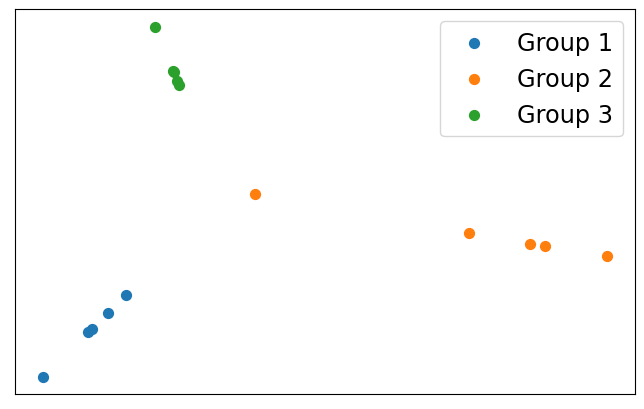

15
silhouette: 0.5569429993629456, ari: 0.7920792079207921
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Cluster: 0.303, [0.421, 0.02, 0.468], 0.36
DS-FL: 0.298, [0.407, 0.021, 0.464], 0.362
FedDF: 0.299, [0.404, 0.021, 0.471], 0.359
sever idcs: 500
data_per_class_3: 165, data_per_class_7: 0
test_data: 500
Global Logit's Accuracy: 29.00%
acc before distill: 0.62, [0.719, 0.435, 0.705], 0.238
[1 1 1 1 1 0 0 0 0 0 2 2 2 2 2]


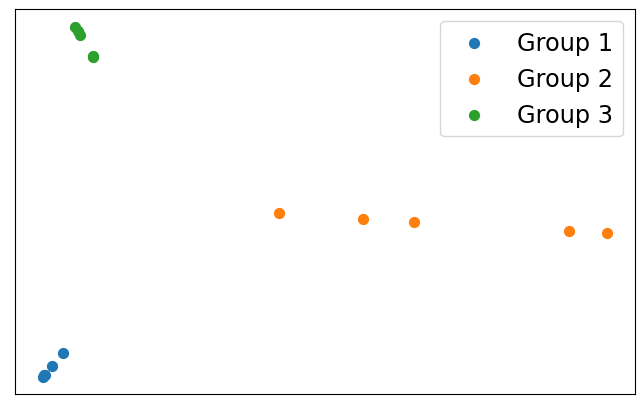

15
silhouette: 0.6022175550460815, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Cluster: 0.318, [0.434, 0.032, 0.489], 0.371
DS-FL: 0.306, [0.42, 0.027, 0.47], 0.374
FedDF: 0.306, [0.416, 0.03, 0.471], 0.372
sever idcs: 500
data_per_class_3: 165, data_per_class_7: 0
test_data: 500
Global Logit's Accuracy: 30.60%
acc before distill: 0.595, [0.667, 0.478, 0.64], 0.229
[1 1 1 1 1 2 2 2 2 2 0 0 0 0 0]


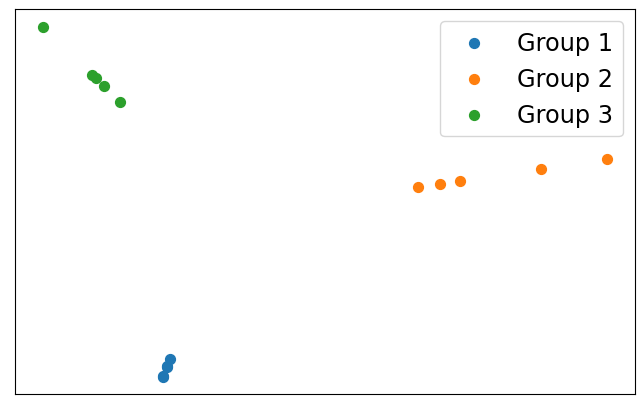

15
silhouette: 0.5290471315383911, ari: 1.0
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Cluster: 0.322, [0.47, 0.058, 0.439], 0.445
DS-FL: 0.315, [0.471, 0.035, 0.439], 0.431
FedDF: 0.322, [0.478, 0.042, 0.446], 0.451
sever idcs: 500
data_per_class_3: 165, data_per_class_7: 0
test_data: 500
Global Logit's Accuracy: 27.60%
acc before distill: 0.55, [0.556, 0.448, 0.647], 0.185
[0 2 2 2 2 0 0 0 0 0 1 1 0 1 1]


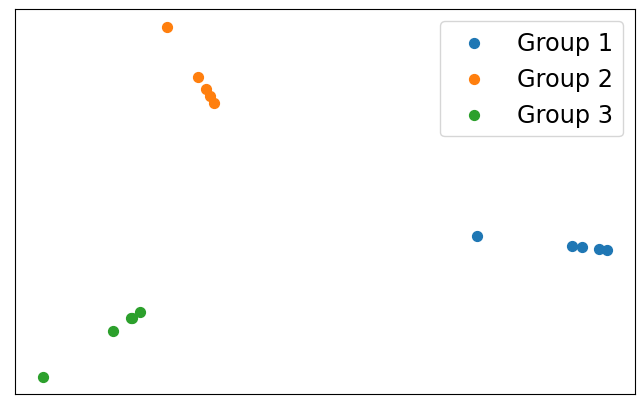

15
silhouette: 0.4121245741844177, ari: 0.56957928802589
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
client 0 distill
client 10 distill
Cluster: 0.3, [0.321, 0.04, 0.538], 0.234
DS-FL: 0.29, [0.302, 0.034, 0.536], 0.239
FedDF: 0.297, [0.313, 0.044, 0.534], 0.233


In [9]:
import pandas as pd

t = 2
data_per_client = 500
group_count = 3
# The following three lines are not needed as per your request to remove the iteration over them
instance_per_class = 165
instance_per_minor_class = 0
minor_class_ratios = 0

all_results = []

# Iterating over class_per_group values (2, 3, 4, 5)
for class_per_group in range(2, 6):  

    # Update cluster_distribution based on new group_count
    cluster_distribution = [1/group_count for i in range(1, group_count+1)]
    
    # Initialize n_clients based on group_count
    n_clients = group_count * 5

    instances_per_class_per_client = get_combination(group_count, class_per_group)

    # Run the experiment
    # Since you've removed the iteration over minor_class_ratio, instance_per_class, and instance_per_minor_class,
    # you'll need to provide these values to the function call if it requires them.
    client_accs, cluster_accs, global_accs = cluster_train_result_exp(
        n_clients, 40000, 500, group_count, cluster_distribution, instance_per_class, instance_per_minor_class, instances_per_class_per_client, t
    )

    # Append to the list as a dictionary, extracting the required indices from client_accs
    all_results.append({
        'class_per_group': class_per_group,
        'group_count': group_count,
        'acc_before': client_accs[-4],
        'acc_FedAVG': client_accs[-3],
        'acc_ds-fl': client_accs[-2],
        'acc_feddf': client_accs[-1]
    })

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(all_results)


In [10]:
all_results

[{'class_per_group': 2,
  'group_count': 3,
  'acc_before': 0.617,
  'acc_FedAVG': 0.303,
  'acc_ds-fl': 0.298,
  'acc_feddf': 0.299},
 {'class_per_group': 3,
  'group_count': 3,
  'acc_before': 0.668,
  'acc_FedAVG': 0.318,
  'acc_ds-fl': 0.306,
  'acc_feddf': 0.306},
 {'class_per_group': 4,
  'group_count': 3,
  'acc_before': 0.672,
  'acc_FedAVG': 0.322,
  'acc_ds-fl': 0.315,
  'acc_feddf': 0.322},
 {'class_per_group': 5,
  'group_count': 3,
  'acc_before': 0.568,
  'acc_FedAVG': 0.3,
  'acc_ds-fl': 0.29,
  'acc_feddf': 0.297}]

In [11]:
df

,class_per_group,group_count,acc_before,acc_FedAVG,acc_ds-fl,acc_feddf
0,2,3,0.617,0.303,0.298,0.299
1,3,3,0.668,0.318,0.306,0.306
2,4,3,0.672,0.322,0.315,0.322
3,5,3,0.568,0.300,0.290,0.297


In [12]:
# df.to_csv('./results/large_group')